The goal here is to evaluate one strategy for enabling similarity search of virtual libraries defined via molecular fragments that can be combined using simple rules. One obvious approach is to just enumerate the molecules in the library, generate their fingerprints, and the calculate similarity. This is clearly impractical if the libraries are really big, so I want to see if it's possible to make things faster by skipping the enumeration step and approximating the fingerprint of a molecule with the sum of the fingerprints that make it up plus constant correction terms.

For example, suppose I form a molecule by combining the two fragments `c1ccccc1-[16*]` and `CCCCO-[3*]` to make `c1ccccc1-OCCCC`, I want to see how closely I can approximate the fingerprint of the final molecule by adding the fingerprints of the two fragments together with a correction term that is characteristic of the bond type being formed (in this case the `16-3` combination rule). This obviously won't work well with fingerprints like Atom Pairs that include terms encompassing the entire molecule, but may be useful for more "local" descriptors like the Morgan fingerprint, topological torsions, or the RDKit fingerprint.

Demonstrating that this really works requires a fair amount of effort, but we can get a good initial readout by comparing the calculated similarities between a bunch of real molecules calculated with their "real" fingerprints and then with the "additive" fingerprints. I'll start here with the Morgan fingerprint, since that's one of the more popular ones in the RDKit (and one where the approach seems likely to work). If that goes well, I'll try another fingerprint type or two and maybe do some more comprehensive validation.

In [1]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem import BRICS
import rdkit
rdkit.__version__
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Start by reading in the set of molecules we'll work with. This dataset was described in a recent [RDKit blog post](https://rdkit.blogspot.com/2019/10/a-new-lessel-and-briem-like-dataset.html).

Bring in the molecules and do salt stripping:

In [3]:
ms = [rdMolStandardize.FragmentParent(x) for x in Chem.SmilesMolSupplier('../data/BLSets_selected_actives.txt')]
len(ms)

6359

In order to fragment the molecules we're going to be using the [BRICS fragmentation rules](http://doi.wiley.com/10.1002/cmdc.200800178) as implemented in the RDKit. Note that the RDKit implementation has differs from the published BRICS rules in that atom types 2 and 5 (both Ns) have been combined with each other. This is, unfortunately not (yet) documented outside of the code itself, but there's an explanation here: https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/ChemTransforms/MolFragmenter.cpp#L101

For the purposes of this evaluation as to whether or not additive fingerprints work, we will only be using the ten most common BRICS bonds in the dataset. Let's start by finding those.

This is what the list of BRICS bonds for each molecule looks like:

In [4]:
list(BRICS.FindBRICSBonds(ms[0]))

[((2, 1), ('1', '5')),
 ((8, 7), ('1', '5')),
 ((6, 7), ('4', '5')),
 ((15, 20), ('5', '12')),
 ((8, 10), ('6', '13')),
 ((6, 30), ('8', '15')),
 ((23, 24), ('8', '16'))]

The first element of each tuple contains the indices of the atoms defining the bond, the second element has the BRICS atom types of those atoms. For example, the first BRICS bond in the molecule above is between atom 2 (BRICS type 1) and atom 1 (BRICS type 5).

Loop over all the molecules and count the number of times each bond type occurs:

In [5]:
from collections import defaultdict, Counter
cntr = Counter()
for m in ms:
    bbnds = BRICS.FindBRICSBonds(m)
    for aids,lbls in bbnds:
        cntr[lbls] += 1
freqs = sorted([(y,x) for x,y in cntr.items()],reverse=True)
freqs[:10]

[(7337, ('4', '5')),
 (4619, ('1', '5')),
 (3488, ('8', '16')),
 (2599, ('3', '16')),
 (1817, ('5', '16')),
 (1507, ('3', '4')),
 (997, ('6', '16')),
 (853, ('5', '15')),
 (790, ('8', '14')),
 (714, ('8', '15'))]

The top two bond types are `4-5`(alkyl C - amine) and `1-5` (the amide bond).

Keep those top 10:

In [6]:
bondsToKeep = [y for x,y in freqs[:10]]

In order to clarify what the more complex code below does, here's a worked example demonstrating fragmenting a single molecule along two bonds, both between BRICS atom types 1 and 5 (these bonds and the types come from the example above where we found the molecule's BRICS bonds):

In [28]:
tm=Chem.FragmentOnSomeBonds(ms[0],[ms[0].GetBondBetweenAtoms(2,1).GetIdx(),ms[0].GetBondBetweenAtoms(8,7).GetIdx()],
                         dummyLabels=[[1,5],[1,5]])
[Chem.MolToSmiles(x) for x in tm]

['[1*]C(=O)C(=O)C(NC(=O)[C@@H]1CC[C@H]2CN(S(=O)(=O)Cc3ccccc3)CC(=O)N21)[C@H]1CC[C@H](N)CC1.[5*]NC',
 '[1*]C(=O)[C@@H]1CC[C@H]2CN(S(=O)(=O)Cc3ccccc3)CC(=O)N21.[5*]NC(C(=O)C(=O)NC)[C@H]1CC[C@H](N)CC1']

To make it visual, here's a drawing of the two fragmentations:

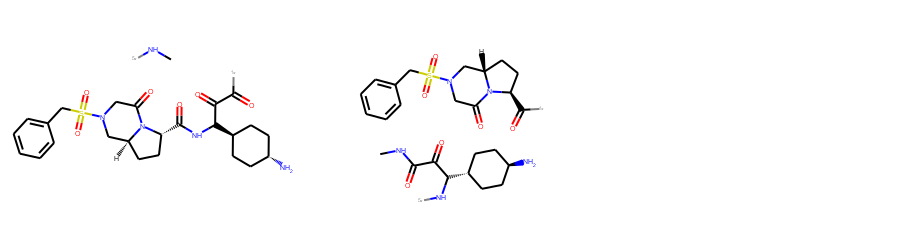

In [14]:
fms = Chem.FragmentOnSomeBonds(ms[0],[ms[0].GetBondBetweenAtoms(2,1).GetIdx(),ms[0].GetBondBetweenAtoms(8,7).GetIdx()],
                         dummyLabels=[[1,5],[1,5]])
Draw.MolsToGridImage(fms,subImgSize=(300,250))

Let's define some functions that we'll use for the rest of this:

In [7]:
def splitMol(mol,bondsToKeep):
    ''' fragments a molecule on a particular set of BRICS bonds. 
    Partially sanitizes the results 
    '''
    bbnds = BRICS.FindBRICSBonds(mol)
    bndsToTry = []
    lbls = []
    for aids,lbl in bbnds:
        if lbl in bondsToKeep:
            bndsToTry.append(mol.GetBondBetweenAtoms(aids[0],aids[1]).GetIdx())
            lbls.append([int(x) for x in lbl])
    if not bndsToTry:
        return []
    res = Chem.FragmentOnSomeBonds(mol,bndsToTry,dummyLabels=lbls)
    # We need at least a partial sanitization for the rest of what we will be doing:
    for entry in res:
        entry.UpdatePropertyCache(False)
        Chem.FastFindRings(entry)
    return res

def getDifferenceFPs(mol,bondsToKeep,fpgen):
    ''' generates the difference fingerprint between the molecule
    and each of its fragmentations based on the BRICS bond types passed in.
    
    This calculates the sum of the fragment fingerprints by just generating the
    fingerprint of the fragmented molecule, so whole-molecule fingerprints like
    atom pairs will not work here. That's fine since they are unlikely to be useful
    with this approach anyway
    '''
    frags = splitMol(mol,bondsToKeep)
    if not frags:
        return []
    res = []
    # get the fingerprint for the molecule:
    molfp = fpgen.GetCountFingerprint(mol)
    # now loop over each fragmentation
    for frag in frags:
        # generate the fingerprint of the fragmented molecule
        # (equivalent to the sum of the fingerprints of the fragments)
        ffp = fpgen.GetCountFingerprint(frag)
        # and keep the difference
        res.append(molfp-ffp)
    return res

def getSumFP(fragMol,fpgen,delta):
    ''' Constructs the sum fingerprint for a fragmented molecule using
    delta as a constant offset
    
    note that any elements of the fingerprint that are negative after adding the
    constant offset will be set to zero
    
    '''
    ffp = fpgen.GetCountFingerprint(fragMol)
    for idx,v in delta.GetNonzeroElements().items():
        tv = ffp[idx] + v
        if tv<0:
            tv = 0;
        ffp[idx] = tv
    return ffp
        

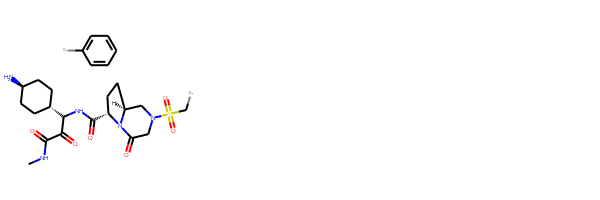

In [15]:
# demonstrate what splitMol returns:
frags = splitMol(ms[0],bondsToKeep[2:3])
Draw.MolsToGridImage(frags)

Now walk through the analysis with a single bond type: `1-5`

The first thing we need to do is determine the constant offset term for this bond type. We will do that by generating difference fingerprints for all the fragmentations it generates and then averaging those difference fingerprints.

Start by generating the difference fingerprints for all the fragmentations using that bond type:

In [20]:
# for this analysis we will use a 4096 "bit" count-based Morgan fingerprints with a radius of 2
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
dfps= []
for m in ms:
    dfps.extend(getDifferenceFPs(m,bondsToKeep[1:2],fpgen))

Now find the average value of the difference fingerprint, being careful to keep only integer values:

In [19]:
delta1 = dfps[0]
for dfp in dfps[1:]:
    delta1 += dfp
nfps = len(dfps)
for k,v in delta1.GetNonzeroElements().items():
    delta1[k] = round(v/nfps)
delta1.GetNonzeroElements()

{226: -2, 264: -1, 1831: -1}

To quickly summarize that this is telling us: We can simulate the MFP2 fingerprint for a molecule by adding the MFP2 fingerprints of its bond type `1-5` fragments and then substracting one each from the values for bits 264 and 1831 and two from the value for bit 226.

Let's look at how well that works across all the molecules. We start by generating the full FP and the `1-5` fragment FP for every molecule that has a `1-5` fragment:

In [17]:
allfps = []
for m in ms:
    frags = splitMol(m,bondsToKeep[1:2])
    if not frags:
        continue
    fp1 = fpgen.GetCountFingerprint(m)
    ffps = [getSumFP(x,fpgen,delta1) for x in frags]
    allfps.append((fp1,ffps))

In [96]:
len(allfps)

2801

And calculate the similarity of each molecule to itself by calculating the Tanimoto similarity between the full fingerprint and the fragment fingerprint:

In [106]:
self_tanis = []
for fp1,ffps in allfps:
    self_tanis.extend([DataStructs.TanimotoSimilarity(fp1,x) for x in ffps])

Visualize those:

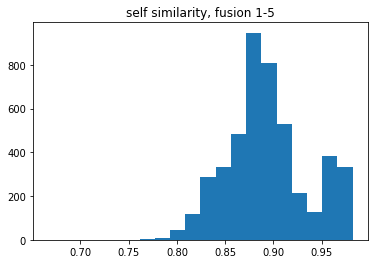

In [107]:
hist(self_tanis,bins=20);
title("self similarity, fusion 1-5");

Though that's interesting, and good to see that the self-similarities aren't all too far from 1.0, we're actually more interested in using the fingerprints for comparing different molecules to each other.

Look at a bunch of random pairs of molecules that are at least 0.3 similar to each other (the [noise threshold](http://rdkit.blogspot.com/2013/10/fingerprint-thresholds.html) for count-based MFP2 is around 0.3), and then look at how different the similarities between their normal and fragment fingerprints are.

In [116]:
import random
random.seed(0xf00d)
ps1 = list(range(len(allfps)))
random.shuffle(ps1)
ps1 = ps1[:500]
ps2 = list(range(len(allfps)))
random.shuffle(ps2)
ps2 = ps2[:500]

nCompared = 0
other_tanidiff = []
for i in ps1:
    fp1,frags1 = allfps[i]
    for j in ps2:
        fp2,frags2 = allfps[j]
        refTani = DataStructs.TanimotoSimilarity(fp1,fp2)
        if refTani < 0.3:
            continue
        nCompared += 1
        ltanis = []
        for f1 in frags1:
            ltanis.extend(DataStructs.BulkTanimotoSimilarity(f1,frags2))
        other_tanidiff.extend([refTani-x for x in ltanis])
print(f"considered {nCompared} fingerprint pairs from {len(allfps)**2}")

considered 15242 fingerprint pairs from 7845601


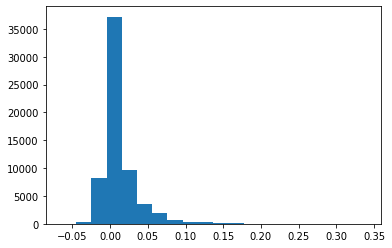

In [113]:
hist(other_tanidiff,bins=20);

In [114]:
len(other_tanidiff)

62521

That's looks pretty good. For at least the `1-5` fragmentation, the similarity calculated with the fragment fingerprint is quite similar t othat calculated with the full fingerprint. Even better: most of the deviation happens to the high-similarity side, so we should be able to safely use the fragment-fingerprint similarity as a filter to identify interesting molecules. 

Repeat that analysis for each of the top 10 fragmentations:

In [8]:
import random
random.seed(0xf00d)
results = {}
for btk in bondsToKeep:
    print(f"Doing {btk}")
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
    dfps= []
    for m in ms:
        dfps.extend(getDifferenceFPs(m,[btk],fpgen))

    delta1 = dfps[0]
    for dfp in dfps[1:]:
        delta1 += dfp
    nfps = len(dfps)
    for k,v in delta1.GetNonzeroElements().items():
        delta1[k] = round(v/nfps)
    delta1.GetNonzeroElements()

    allfps = []
    for m in ms:
        frags = splitMol(m,[btk])
        if not frags:
            continue
        fp1 = fpgen.GetCountFingerprint(m)
        ffps = [getSumFP(x,fpgen,delta1) for x in frags]
        allfps.append((fp1,ffps))

    self_tanis = []
    for fp1,ffps in allfps:
        self_tanis.extend([DataStructs.TanimotoSimilarity(fp1,x) for x in ffps])
        
    ps1 = list(range(len(allfps)))
    random.shuffle(ps1)
    ps1 = ps1[:1000]
    ps2 = list(range(len(allfps)))
    random.shuffle(ps2)
    ps2 = ps2[:1000]

    nCompared = 0
    other_tanidiff1 = []
    other_tanidiff2 = []
    for i in ps1:
        fp1,frags1 = allfps[i]
        for j in ps2:
            fp2,frags2 = allfps[j]
            refTani = DataStructs.TanimotoSimilarity(fp1,fp2)
            if refTani < 0.3:
                continue
            nCompared += 1
            ltanis = []
            for f1 in frags1:
                ltanis.extend(DataStructs.BulkTanimotoSimilarity(f1,frags2))
            other_tanidiff1.extend([refTani-x for x in ltanis])
            other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp1,frags2)])
            other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp2,frags1)])

    print(f"considered {nCompared} fingerprint pairs from {len(allfps)**2}")
    results[btk] = (self_tanis,other_tanidiff1,other_tanidiff2)


Doing ('4', '5')
considered 66995 fingerprint pairs from 18326961
Doing ('1', '5')
considered 63242 fingerprint pairs from 7845601
Doing ('8', '16')
considered 54070 fingerprint pairs from 6095961
Doing ('3', '16')
considered 95650 fingerprint pairs from 4260096
Doing ('5', '16')
considered 217114 fingerprint pairs from 2725801
Doing ('3', '4')
considered 112805 fingerprint pairs from 1537600
Doing ('6', '16')
considered 98275 fingerprint pairs from 790321
Doing ('5', '15')
considered 53490 fingerprint pairs from 640000
Doing ('8', '14')
considered 43370 fingerprint pairs from 504100
Doing ('8', '15')
considered 35148 fingerprint pairs from 352836


Start, again, by looking at self similarities.

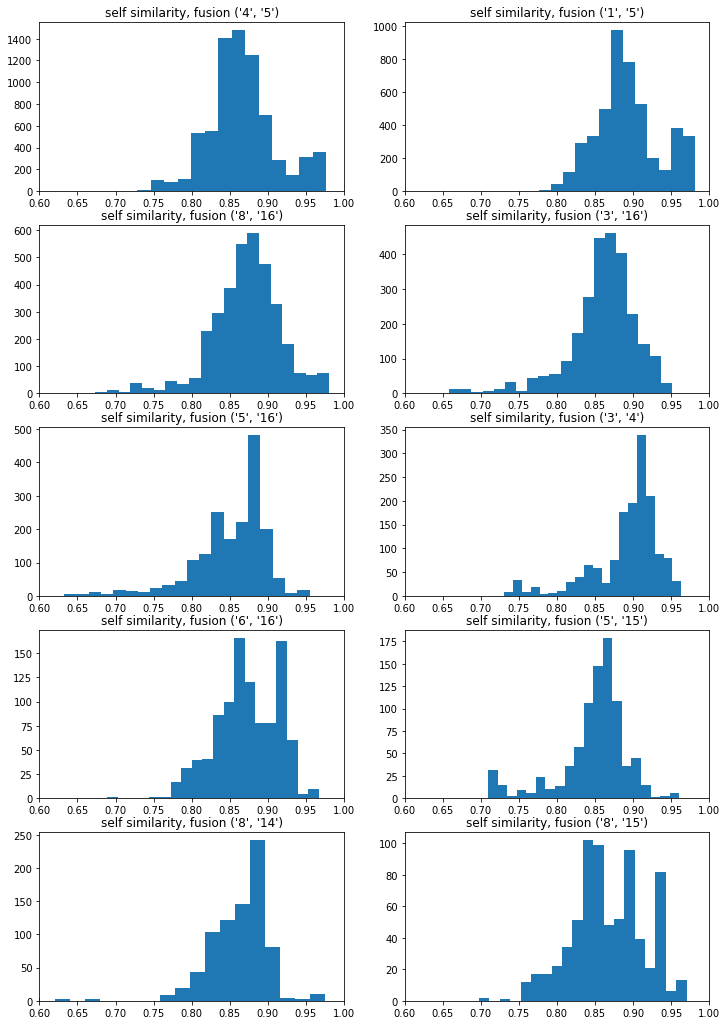

In [9]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(self_tanis,bins=20);
    title(f"self similarity, fusion {btk}");    
    xlim((0.6,1.0))

Look at the more interesting fragment-fragment similarity:

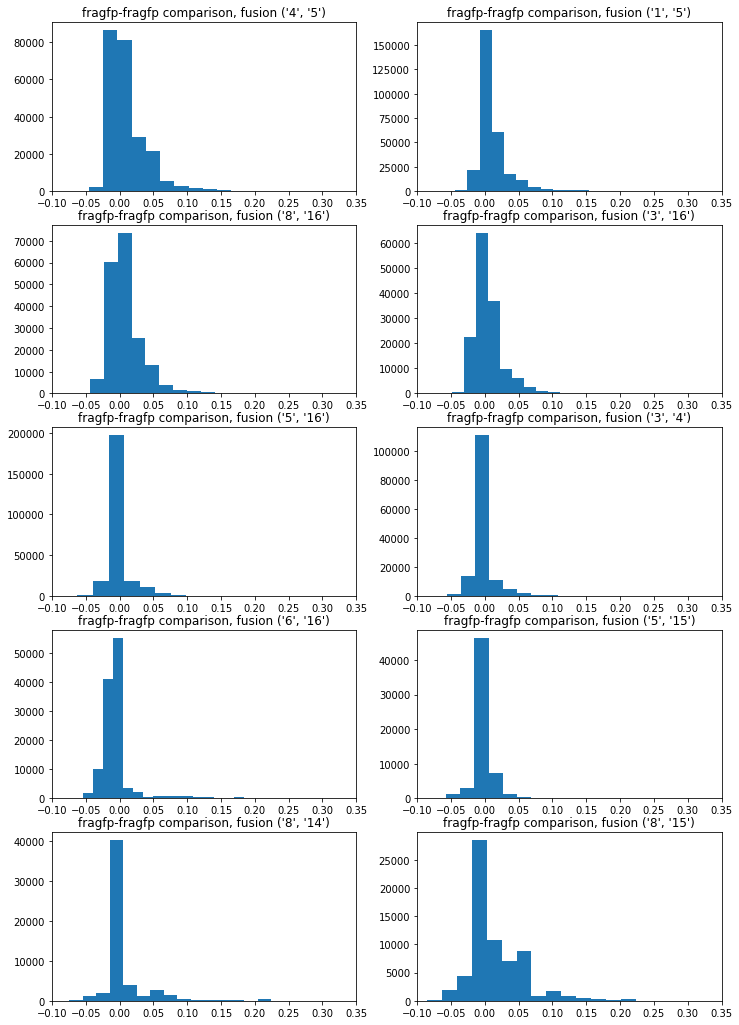

In [10]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(other_tanidiff1,bins=20);
    title(f"fragfp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.35));

And, finally, since we could query the collection of fragment molecules with a full fingerprint, look at the difference between the full FP similarity and the full FP - fragment FP similarity:

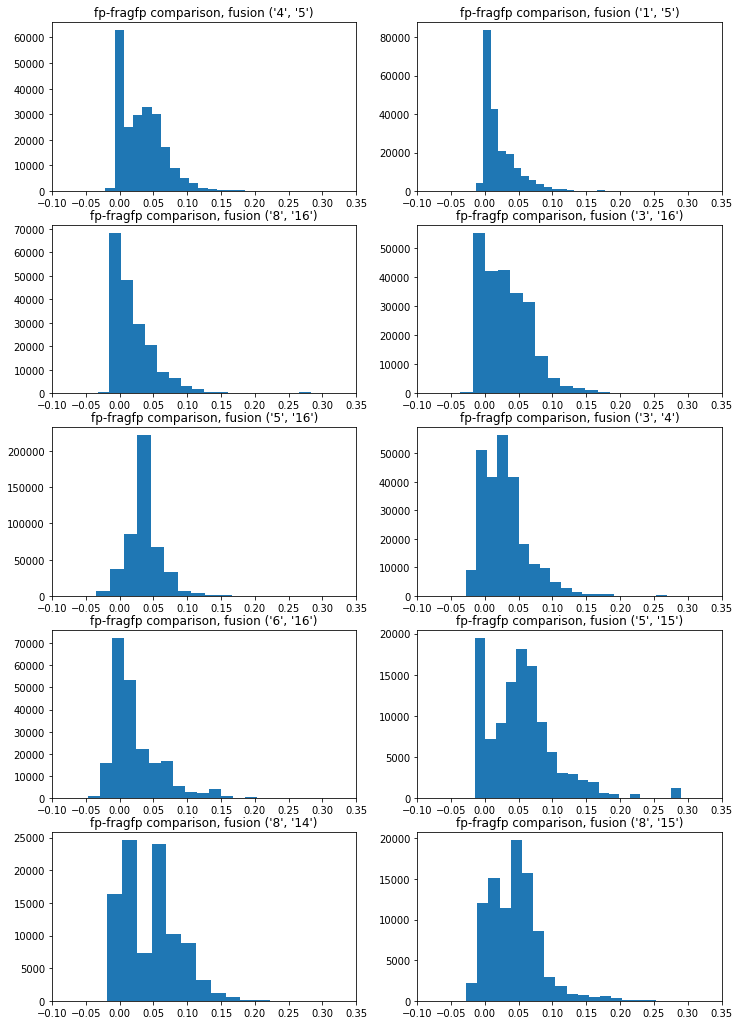

In [11]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(other_tanidiff2,bins=20);
    title(f"fp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.35));

Further ToDos:

- look at how well these constants work across different molecules
- look at the difference the constant term makes, what happens if we leave it out entirely?
- look at fragmenting the molecule multiple times
- look at an asymmetric similarity measure like Tversky?

In [28]:
fp1 = fpgen.GetFingerprint(Chem.MolFromSmiles('c1ccccc1'))
fp2 = fpgen.GetFingerprint(Chem.MolFromSmiles('c1ccccc1.C1CCCC1'))

#DataStructs.CosineSimilarity(fp1,fp2),DataStructs.TanimotoSimilarity(fp1,fp2),\
DataStructs.TverskySimilarity(fp1,fp2,0.25,0.75),DataStructs.TverskySimilarity(fp2,fp1,0.15,0.85)

(0.5714285714285714, 0.8695652173913044)